## MNIST 다운로드

In [2]:
import warnings

warnings.filterwarnings(action='ignore')

In [3]:
from shutil import copyfileobj
from six.moves import urllib
from sklearn import datasets
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = datasets.get_data_home(data_home=data_home)
    
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

fetch_mnist()

In [4]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
mnist

C:\Users\newxe\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\newxe\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [5]:
X, y = mnist["data"], mnist["target"]

print("train data : ",X.shape) # 28x28
print("label data : ",y.shape)


train data :  (70000, 784)
label data :  (70000,)


## 이미지 개수 : 70000개
## 이미지 픽셀 : 784(28 x 28) pixels
## 픽셀의 특성 : 0(흰색) ~ 255(검정색

5.0


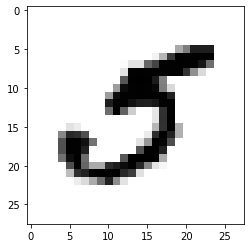

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

index = 36000

some_digit  = X[index]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")

print(y[index])

## 1. 학습 / 테스트 분리
## 2. 교차검증의 fold를 비슷하게 하기위해 섞는다.
## 3. 값이 5일때 true 훈련 진행

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index], y_train[shuffle_index]

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## 확률적 경사 하강법
## SGD(Stochastic Gradient Descent) 분류기로 
## 문제를 다룬다

In [10]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=5, random_state=42)
sgd.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [11]:
sgd.predict([some_digit]) # true or false

array([ True])

## 교차검증을 진행
## 아래 코드는 cross_val_score와 거의 동일한 작업을 수행하고, 동일한 결과를 제공
## 3개의 검증 fold

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.96185
0.96095
0.95115


In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.96185, 0.96095, 0.95115])

## '5'아님 클래스로 분류하는 더미 분류기

In [20]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator): #5가 아닌것을 찾는 추정기
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

## 정확도가 90% !!
## 하지만 정확도가 이렇게 높은 이유는 이미지의 10% 정도만 숫자 5이기 때문에 무조건 맞출확률은 90% 이상

## 그래서 성능 측정 지표로 정확성을 선호하지 않는다. 
## 특히 불균형한 데이터셋을 다룰 때(특정 클래스가 다른 것보다 월등히 많은 경우) 더욱 그렇다.

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.9096 , 0.9112 , 0.90815])

## 오차행렬(confusion matrix)

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd,X_train,y_train_5,cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53504,  1075],
       [ 1446,  3975]], dtype=int64)

## TN : 5가 아닌 이미지를 5가 아니라고 분류했다. (True Negative)
## FN : 5인 이미지를 5가 아니라고 분류했다. (False Negative)
## FP : 5가 아닌 이미지를 5라고 분류했다. (Fasle Positive)
## TP : 5인 이미지를 5라고 분류했다.(True Positive)

## 오차행렬 자체도 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요.

In [59]:
from sklearn.metrics import precision_score, recall_score

#정밀도 : 예측 정답이 10개인데 5개 맞았음
print('precision : ', precision_score(y_train_5, y_train_pred))
#재현율 : 실제 정답이 10개인데 3개 찾았음
print('recall : ', recall_score(y_train_5, y_train_pred))

precision :  0.7871287128712872
recall :  0.7332595462091865


## 5로 예측한 이미지 중 78%가 정확.
## 전체 예측할 숫자 5에서 73%만 정확히 예측.
# ------------------------------------------------------------
## F1-score
### 정밀도와 재현율을 하나로 묶어서 만든 것(precisio 과 recall의 조화 평균)

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.759239805176201

# 정밀도 / 재현율 trade-off
## 정밀도가 높으면 재현율이 줄고, 재현율이 높으면 정밀도가 줄어든다.
# 결정 함수
## 결정함수를 사용해서 각 샘플의 점수를 계산.
## 이 점수가 임계 값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다.

In [26]:
y_scores = sgd.decision_function([some_digit])
y_scores

array([256434.68784621])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
threshold=200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

# 임계값을 정하는 법?
## 1. 모든 샘플의 결정 점수를 구함.
## 2. 모든 임계값에 대해서 precision 과 recall을 구함.
## ->precision_recall_curve()

In [29]:
y_scores = cross_val_predict(sgd,X_train,y_train_5,cv=3,method="decision_function")

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

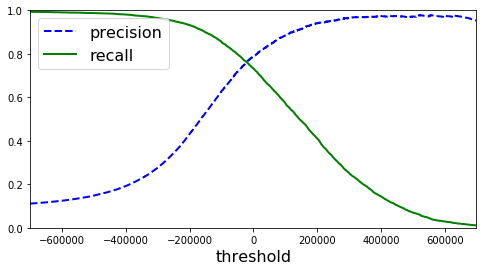

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall",linewidth=2)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

# 임계값을 정하는 법?
## 재현율에 대한 정밀도 곡선을 그리면 좋은 trade-off를 선택할 수 있다.

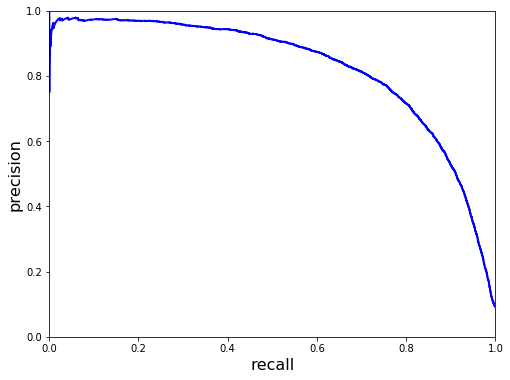

In [34]:
def plot_precision_vs_recall(precsions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recall", fontsize=16)
    plt.ylabel("precision",fontsize=16)
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
plt.show()


In [35]:
y_train_pred_90 = (y_scores > 70000)

In [37]:
precision_score(y_train_5,y_train_pred_90)

0.8608850457782299

In [38]:
recall_score(y_train_5,y_train_pred_90)

0.6244235380926029

## ROC 곡선
## 이진 분류에서 널리 사용하는 도구다.

### 정밀도/재현율 곡선과 비슷하지만, 
### 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)을 나타낸다. 

## FPR : 양성으로 잘못 분류된 음성 샘플의 비율(1 - TNR)
## TNR : 특이도

## ROC 곡선 : 재현율에 대한 1 – TNR(특이도) 그래프

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

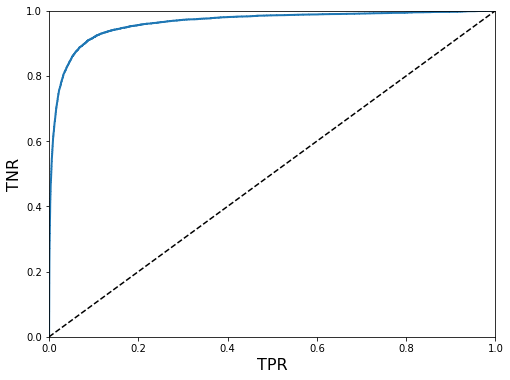

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('TPR', fontsize=16)
    plt.ylabel('TNR', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

## AUC : 곡선 아래 면적
## AUC가 1에 가까울 수록 완벽한 분류기 이고, 0.5면 완전한 랜덤 분류기

### roc_auc_score() 함수를 제공
# --------------------------------------------------------------------------------

# Receiver Operating Characteristric
## ROC vs PR
### 일반적인 법칙은 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용
### 조금 전의 ROC 곡선을 보면 AUC 점수를 봤을 때 매우 좋은 분류기라고 생각할 수 있음.
### 하지만 이는 음성(5가 아님)에 비해 양성(5)이 크게 적기 때문에 나타나는 결과이며, 이오는 다르게 PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지 잘 보여준다.
# --------------------------------------------------------------------------------
## RandomForest와 SGD의 ROC 곡선과 ROC AUC를 비교해 보자

### 1. 학습데이터의 샘플에 대한 점수를 얻어야한다.

### 2. 작동 방식이 달라서 RandomForest는 decision_function이 없다.
### 	-> predict_proba() 함수가 있다.

### 3. predict_proba는 점수가 아닌 확률을 반환한다.

In [45]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest, X_train, y_train_5, cv=3, method="predict_proba")

In [46]:
y_scores_forest = y_probas_forest[:, 1] # 점수는 앙상 클래스의 확률입니다
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

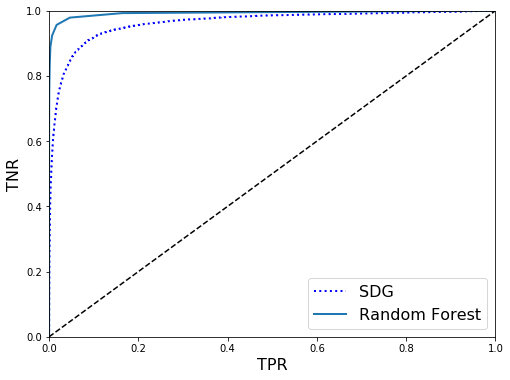

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SDG")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

# 다중 분류

### 이제까지 5인지 아닌지 구분하는 이진 분류였다면 
#### 이번에는 0 ~ 9를 분류하는 다중 분류를 진행한다.

## 방법 

## 일대다(OvA) : 이진 분류기 10개를 훈련시켜서 다중 분류기를 만드는 방법이 있다. 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택

## 일대일(OvO) : 각 숫자의 조합(0,1구별, 0,2구별 …)마다 이진 분류기를 훈련시키는 방법이 있다. 45개의 분류기가 필요하다.

### SVM 같은 경우는 큰 학습데이터를 몇 개의 분류기로 훈련하는 것보다 작은 학습데이터를 많은 분류기로 훈련하는 것이 좋다.(OvO 선호)

### 하지만 대부분 OvA를 선호한다.

In [48]:
sgd.fit(X_train, y_train) #이제부터 y_train_5->y_train
sgd.predict([some_digit])

array([5.])

In [50]:
some_digit_scores = sgd.decision_function([some_digit])
some_digit_scores

array([[ -57380.33520188, -429489.76392276, -483740.70644688,
        -360719.78528602, -421162.02504654,  208572.55178598,
        -599202.95182266, -314984.14637483, -847379.87633941,
        -575039.21299506]])

In [51]:
np.argmax(some_digit_scores)

5

In [52]:
sgd.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [53]:
sgd.classes_[5]

5.0

## 강제로 OvA, OvO 사용하기 : OneVsRestClassifier, OneVsOneClassifier

In [62]:
from sklearn.multiclass import OneVsOneClassifier
ovo = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo.fit(X_train,y_train)
ovo.predict([some_digit])

array([3.])

In [58]:
len(ovo.estimators_)

45

## RandomForest는 직점 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvA와 OvO를 적용할 필요는 없다.

In [63]:
forest.fit(X_train, y_train)
forest.predict([some_digit])

array([5.])

In [64]:
forest.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

# 분류기 평가
## 일반적으로 교차 검증을 이용해서 평가한다.

In [65]:
cross_val_score(sgd,X_train,y_train,cv=3,scoring="accuracy")

array([0.88697261, 0.87054353, 0.8640296 ])

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.91141772, 0.90724536, 0.91113667])

### 성능이 80%에서 더 높일 필요가 없기 때문에 간단하게 스케일만 조정해서 정확도를 90% 이상으로 높인다.
# ------------------------------------------------------------------------------------
## 에러 분석
### 먼저 오차 행렬을 살펴보면서 에러의 종류를 분석.

In [70]:
y_train_pred = cross_val_predict(sgd,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5721,    3,   30,   11,   12,   50,   46,    9,   38,    3],
       [   1, 6480,   45,   27,    6,   35,    8,   13,  114,   13],
       [  58,   41, 5329,  102,   83,   25,   79,   56,  168,   17],
       [  46,   45,  128, 5364,    2,  221,   37,   57,  128,  103],
       [  20,   31,   36,   10, 5369,    8,   53,   28,   76,  211],
       [  66,   47,   35,  188,   79, 4583,  116,   29,  184,   94],
       [  32,   27,   54,    2,   42,   84, 5623,    4,   49,    1],
       [  23,   22,   64,   29,   54,    9,    8, 5818,   13,  225],
       [  56,  156,   65,  166,   12,  146,   61,   30, 5024,  135],
       [  42,   36,   27,   92,  149,   34,    3,  209,   72, 5285]],
      dtype=int64)

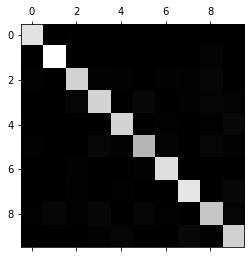

In [71]:
plt.matshow(conf_mx,cmap=plt.cm.gray)

### 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 좋아보인다.

# 에러 분석
## 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교

In [72]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

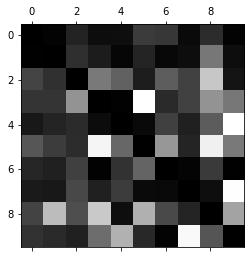

In [73]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## 상대적으로 8과 9 행과 열이 밝다.
### -> 다른 숫자와 혼동된다.

## 1열 부분은 매우 어둡다.
### -> 분류가 잘되었다. 

## 3이랑 5가 매우 혼동이 잘된다.

In [75]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size* n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

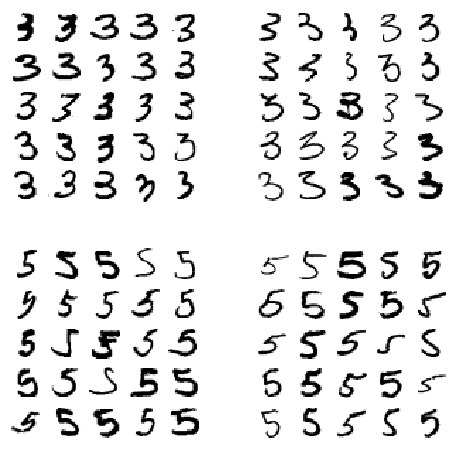

In [77]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 오른쪽 2블록은 5로 분류됨
# 왼쪽 2블록은 3으로 분류됨

# 실수의 원인 : SGD를 사용했기 때문이다.
## -> 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다.

### 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동한다.

### 3과 5의 주요차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치다.

### 연결부위가 왼쪽으로 치우치면 3 오른쪽으로 치우지면 5

### 3과 5의 에러를 줄이는 방법은 이미지를 중앙에 위치시키고 회전되어있지 않도록 전처리하는 것이다. 이렇게 하면 다른 에러도 줄어들 것이다.

# --------------------------------------------------------------------------------------
# 다중 레이블 분류
### 예를 들어 얼굴을 인식하는 분류기에서 한 사진에 A와 C가 있을 경우 분류기의 레이블은 [1,0,1]을 출력해야한다.

## 레이블 = [큰 값(7,8,9), 홀수]

## KNeighborsClassifier 인스턴스를 만들고 다중 타켓 배열을 사용해 훈련시킨다.

In [78]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [79]:
knn.predict([some_digit])

array([[False,  True]])

### 숫자 5는 크지 않고 홀수 이므로 값이 제대로 출력이 되었다.
## 코드실행 하지말고 SKIP

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

### 이 코드는 모든 레이블의 가중치가 같다고 가정한다.

### 만약 예를 들어, A의 사진이 B나 C보다 많다면 A의 사진에 대한 분류기의 점수에 더 높은 가중치를 둘 것이다.

### 간단한 방법은 레이블에 클래스의 지지도(타겟 레이블에 속한 샘플수)를 가중치로 두는 것이다.

### 해당 코드에서 average = ‘weighted’로 변경하면 가능하다.
# --------------------------------------------------------------------------------------
## 다중 출력 분류

### 다중 입력으로 다중의 출력을 예측하는 분류기

### 예제로 노이즈를 제거하는 시스템을 만들어보자
### 노이즈 숫자 이미지를 입력 -> 깨끗한 숫자 이미지를 출력

### 이미지는 픽셀의 집합이기 때문에 다중 입력 다중 출력 분류기다.

## 학습 : 노이즈 이미지
## 라벨 : 깨끗한 이미지

In [81]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

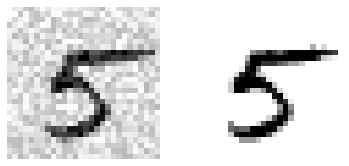

In [82]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

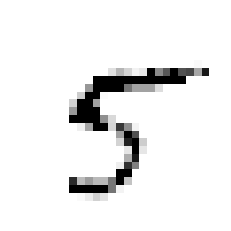

In [83]:
knn.fit(X_train_mod, y_train_mod)
clean_digit = knn.predict([X_test_mod[some_index]])
plot_digit(clean_digit)